In [ ]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import glob
import dask.dataframe as dd
import seaborn as sns
import matplotlib.pyplot as plt
from dask.diagnostics import ProgressBar
from sklearn.ensemble import ExtraTreesClassifier
import numpy as np
from sklearn import preprocessing
%matplotlib inline

## Identify rudimentary ground truth

The 'meta codes' referred to the type of match between left and right metadata, for title (T), Author (A), publish date (P), oclc number (O), page count (C), and Description/enumchron (D).

In [2]:
ddf = dd.read_parquet('/data/saddl/tmp-ground-truth/*')
ddf

,left,right,meta_code
npartitions=71,,,
,object,object,object
,...,...,...
...,...,...,...
,...,...,...
,...,...,...


In [3]:
top_codes = ddf.meta_code.value_counts().compute()

In [4]:
# SWSM
# Perfectly identical, has entry in Description and it matches
top_codes[top_codes.index.str.contains('^T1A1P1O1C[12]D1')]

T1A1P1O1C2D1    6451
T1A1P1O1C1D1    2657
Name: meta_code, dtype: int64

In [5]:
# Diff vol
# same title+date+oclc, but different page count and description
top_codes[top_codes.index.str.contains('^T1A1P1O1C0D0')]

T1A1P1O1C0D0    15412
Name: meta_code, dtype: int64

In [6]:
# SWDE
# same title+date+oclc, but different page count and description
top_codes[top_codes.index.str.contains('^T1A1P.O0C0D.')]

T1A1P0O0C0D2    5237
T1A1P0O0C0D3    1056
T1A1P0O0C0D0    1023
T1A1P1O0C0D2     564
T1A1P1O0C0D0     394
T1A1P0O0C0D1     387
T1A1P1O0C0D3     260
T1A1P1O0C0D1     157
Name: meta_code, dtype: int64

In [7]:
top_codes[top_codes.index.str.contains('T0A0P0O0C0D.')]

T0A0P0O0C0D2    108041
T0A0P0O0C0D3     66899
T0A0P0O0C0D0     11583
T0A0P0O0C0D1       805
Name: meta_code, dtype: int64

In [8]:
select = ddf[ddf.meta_code.str.contains('T1A1P.O0C0D.|T1A1P1O1C0D0|T1A1P1O1C[12]D1|T0A0P0O0C0D.')]
select['meta_code'] = select.meta_code.str.replace('T1A1P.O0C0D.', 'SWDE').str.replace('T1A1P1O1C0D0', 'WP_DV').str.replace('T1A1P1O1C[12]D1', 'SWSM').str.replace('T0A0P0O0C0D.', 'Unrelated')
select.head()

,left,right,meta_code
1,hvd.32044011361748,msu.31293201540675,SWSM
27,hvd.32044011391109,mdp.39015038907922,Unrelated
30,hvd.32044011391109,mdp.39015008536222,Unrelated
31,hvd.32044011391109,mdp.39015029155267,Unrelated
32,hvd.32044011391109,mdp.39015002996562,Unrelated


## Load Left/Right Content Comparison Stats

In [9]:
stats = dd.read_parquet('/data/saddl/tmp-comp-output/4*')
stats

,LSize,RSize,SW0001Len,SW0004Len,SW0005Len,SW0010Len,gloveLMeanMinSim,gloveLPropDist0002,gloveLPropDist0005,gloveLPropDist0010,gloveLPropDist0020,gloveLPropDist0030,gloveLTruncSim,gloveMeanSim,gloveRMeanMinSim,gloveRPropDist0002,gloveRPropDist0005,gloveRPropDist0010,gloveRPropDist0020,gloveRPropDist0030,gloveRTruncSim,left,minSize,right
npartitions=71,,,,,,,,,,,,,,,,,,,,,,,,
,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,int64,object
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [10]:
# Add columns that show SW Runs as proportions of size
for t in [.1, .4, .5, 1]:
    for s in ['L', 'R']:
        stats[s+'SW{:04.0f}Prop'.format(t*10)] = stats['SW{:04.0f}Len'.format(t*10)] / stats[s+'Size']

In [11]:
with ProgressBar():
    sample = dd.merge(stats, select).compute()

[########################################] | 100% Completed | 22.4s


In [12]:
bsample = sample[~sample.gloveLMeanMinSim.isna()] # Some odd NaNs - check later, ignore now
bsample = bsample.groupby('meta_code', as_index=False).apply(lambda x: x.sample(7000)).sample(frac=1)
bsample.shape

(28000, 33)

## Preprocessing

Trying to scale to a normal-ish distribution.

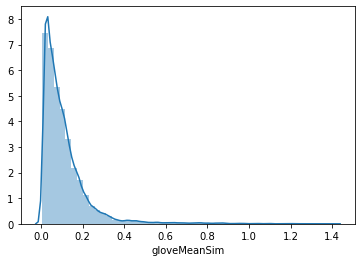

In [46]:
sns.distplot(bsample.gloveMeanSim)

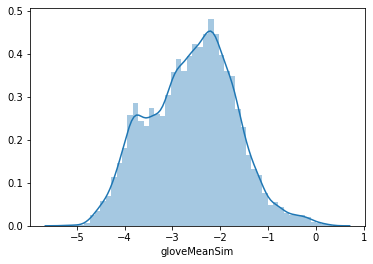

In [48]:
sns.distplot(bsample.gloveMeanSim.apply(np.log))

In [163]:
# Log Transforms, robust scale, no +1
for col in ['gloveMeanSim', 'gloveLMeanMinSim', 'gloveRMeanMinSim', 'gloveLTruncSim', 'gloveRTruncSim']:
    bsample[col+'Transform'] = preprocessing.robust_scale(bsample[col].apply(np.log))

# Feature Importance

In [239]:
featcols = []
for v in ['glove']:
    featcols.append(v+'MeanSimTransform')
    for s in ['L', 'R']:
        featcols += [v+s+'MeanMinSimTransform', v+s+'TruncSimTransform']
        featcols += ['{}{}PropDist{:04.0f}'.format(v,s,t*10) for t in [0.5, 1, 3]] #,0.2]]
        featcols += [s+'SW{:04.0f}Prop'.format(t*10) for t in [.4, .5]] #, .1, 1]]
print(featcols)

['gloveMeanSimTransform', 'gloveLMeanMinSimTransform', 'gloveLTruncSimTransform', 'gloveLPropDist0005', 'gloveLPropDist0010', 'gloveLPropDist0030', 'LSW0004Prop', 'LSW0005Prop', 'gloveRMeanMinSimTransform', 'gloveRTruncSimTransform', 'gloveRPropDist0005', 'gloveRPropDist0010', 'gloveRPropDist0030', 'RSW0004Prop', 'RSW0005Prop']


In [240]:
train = bsample.iloc[:25000]
test = bsample.iloc[25000:]

In [241]:
#featcol_subset = [feat for feat in featcols if not feat.startswith('Right')]
X = train[featcols].values
y = train['meta_code']

In [242]:
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

In [243]:
forest.fit(X, y)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=250,
                     n_jobs=None, oob_score=False, random_state=0, verbose=0,
                     warm_start=False)

In [244]:
testX = test[featcols].values
testy_true = test['meta_code']
y_pred = forest.predict(testX)

In [245]:
from sklearn.metrics import classification_report
print(classification_report(testy_true, y_pred))

              precision    recall  f1-score   support

        SWDE       0.85      0.85      0.85       779
        SWSM       0.91      0.94      0.92       790
   Unrelated       0.90      0.90      0.90       719
       WP_DV       0.83      0.80      0.81       712

    accuracy                           0.87      3000
   macro avg       0.87      0.87      0.87      3000
weighted avg       0.87      0.87      0.87      3000



In [246]:
# from https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-py
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, featcols[indices[f]], importances[indices[f]]))

Feature ranking:
1. gloveRPropDist0005 (0.098213)
2. gloveRPropDist0010 (0.096464)
3. gloveLPropDist0005 (0.085831)
4. gloveLPropDist0010 (0.080589)
5. gloveRPropDist0030 (0.078438)
6. gloveRMeanMinSimTransform (0.077435)
7. gloveMeanSimTransform (0.071982)
8. gloveRTruncSimTransform (0.068007)
9. gloveLPropDist0030 (0.061502)
10. gloveLMeanMinSimTransform (0.059989)
11. gloveLTruncSimTransform (0.056088)
12. RSW0005Prop (0.046370)
13. RSW0004Prop (0.040665)
14. LSW0005Prop (0.040441)
15. LSW0004Prop (0.037986)


# Investigating outliers

In [640]:
quantiles = stats.quantile([.1, 0.2, .25, .3, .4, .5, .6, .7, .75, .8, .9]).compute()
quantiles

,LSize,RSize,SW0001Len,SW0004Len,SW0005Len,SW0010Len,gloveLMeanMinSim,gloveLPropDist0002,gloveLPropDist0005,gloveLPropDist0010,...,LeftSW0005Prop,LeftSW0010Prop,LSW0001Prop,RSW0001Prop,LSW0004Prop,RSW0004Prop,LSW0005Prop,RSW0005Prop,LSW0010Prop,RSW0010Prop
0.10,4.0,10.0,0.0,0.0,0.0,0.0,0.001208,0.000000,0.000000,0.000000,...,0.000000,0.000000,-0.333333,-0.083333,-0.333333,-0.058824,-0.333333,-0.058824,-0.333333,-0.041667
0.20,7.0,15.0,0.0,0.0,0.0,0.0,0.002918,0.000000,0.000000,0.000000,...,0.000000,0.000000,-0.166667,-0.052632,-0.142857,-0.040000,-0.142857,-0.037037,-0.111111,-0.025000
0.25,9.0,17.0,0.0,0.0,0.0,0.0,0.003748,0.000000,0.000000,0.125000,...,0.000000,0.000000,-0.111111,-0.047619,-0.100000,-0.032258,-0.090909,-0.029412,-0.066667,-0.016129
0.30,11.0,20.0,0.0,0.0,0.0,0.0,0.005131,0.000000,0.000000,0.333333,...,0.000000,0.000000,-0.083333,-0.037037,-0.066667,-0.023810,-0.062500,-0.021277,-0.031250,-0.008264
0.40,16.0,25.0,0.0,0.0,0.0,6.0,0.008485,0.000000,0.153846,0.631579,...,0.000000,0.318182,-0.050000,-0.027027,-0.030303,-0.013158,-0.024390,-0.009434,0.321429,0.294118
0.50,21.0,31.0,0.0,4.0,6.0,12.0,0.012394,0.102564,0.470775,0.825000,...,0.235294,0.695357,-0.033333,-0.018519,0.109394,0.108893,0.222222,0.210526,0.708333,0.677419
0.60,26.0,38.0,0.0,9.0,11.0,18.0,0.018003,0.289357,0.709677,0.913043,...,0.571429,0.895395,-0.019608,-0.009901,0.416667,0.410256,0.555556,0.551583,0.900000,0.888889
0.70,32.0,45.0,4.0,14.0,16.0,23.0,0.027388,0.510638,0.857143,0.964286,...,0.818182,0.975786,0.090909,0.090909,0.705882,0.705447,0.807692,0.800000,1.000000,0.975489
0.75,36.0,51.0,6.0,17.0,19.0,25.0,0.033935,0.689655,0.916667,1.000000,...,0.900000,1.000000,0.250000,0.250000,0.840000,0.833333,0.896552,0.894737,1.000000,1.000000
0.80,43.0,67.0,11.0,22.0,24.0,32.0,0.049966,0.866667,0.976190,1.000000,...,0.979167,1.000000,0.500000,0.500000,0.943396,0.944444,0.974359,0.978723,1.000000,1.000000


In [641]:
quantiles.loc[0.1, 'gloveLTruncSim'], quantiles.loc[0.9, 'gloveLMeanMinSim']

(0.001130096347099735, 0.18979175069170492)

In [642]:
with ProgressBar():
    match1 = (stats.gloveLTruncSim <=  quantiles.loc[0.2, 'gloveLTruncSim'])
    match2 = (stats.gloveLTruncSim <=  quantiles.loc[0.2, 'gloveRTruncSim'])
    match3 = (stats.gloveLMeanMinSim >=  quantiles.loc[0.8, 'gloveLMeanMinSim'])
    match4 = (stats.LSize > 4) & (stats.RSize > 4)
    to_investigate = stats[match1 & match2 & match3 & match4].compute()
to_investigate.shape

[########################################] | 100% Completed |  4.5s


(907, 36)

In [643]:
to_investigate[['left', 'right']].sample(2)

,left,right
275,nyp.33433075660088,nyp.33433075011365
3701,hvd.32044069771079,wu.89094600145


In [649]:
from compare_tools.configuration import config
from compare_tools.hathimeta import HathiMeta, meta_compare
meta = HathiMeta(config['metadb_path'])
meta

In [650]:
meta_compare("mdp.39015010954140","hvd.hxjvjq", meta)

,title,author,oclc_num,page_count,description
left,The atomic theory of Lucretius contrasted with modern doctrines of atoms and evolution. By John Masson.,"Masson, John.",2722924,288,None
right,The atomic theory of Lucretius contrasted with modern doctrines of atoms and evolution. By John Masson.,"Masson, John.",2722924,272,None


In [646]:
from IPython.core.display import display, HTML
pd.set_option('display.max_colwidth', 2000)
html = ""
for i, row in to_investigate[['left', 'right']].sample(20).iterrows():
    a = meta_compare(row.left, row.right).to_html()
    html += "<hr/><a href='http://hdl.handle.net/2027/{}'>Left</a>&nbsp;<a href='http://hdl.handle.net/2027/{}'>Right</a><br/>".format(row.left, row.right)
    html += a
display(HTML(html))

,title,author,oclc_num,page_count,description
left,Charles Kingsley and the Christian social movement / by Charles William Stubbs.,"Stubbs, Charles William, 1845-1912.",1707237,242,None
right,"Charles Kingsley and the Christian social movement, by Charles William Stubbs.","Stubbs, Charles William, 1845-1912.",5842441,212,None
,title,author,oclc_num,page_count,description
left,Mary Lincoln; biography of a marriage.,"Randall, Ruth Painter.",964413,608,None
right,Mary Lincoln; biography of a marriage.,"Randall, Ruth Painter.",964413,484,None
,title,author,oclc_num,page_count,description
left,"Sucker's progress; an informal history of gambling in America from the colonies to Canfield, by Herbert Asbury.","Asbury, Herbert, 1891-1963.",565296,580,None
right,"Gambling on the western rivers / prepared by the staff of the Public Library, Fort Wayne and Allen County.","Asbury, Herbert, 1891-1963.",3025776,90,None
,title,author,oclc_num,page_count,description
left,"Sports & anecdotes of bygone days in England, Scotland, Ireland, Italy and the Sunny South. By C. T. S. Birch Reynardson.","Reynardson, C. T. S. Birch 1810-1889.",8289671,368,None
